# Superstore Example using KAWA's Python client

## 1. Load the data into KAWA

With this libraary, you can easily load any dataframe or parquet file into KAWA.
It is very useful if you want to connect to your internal systems or APIs, if you want to ingest real time data,
or if you have large volumes of data that you wish to ingest quickly.

Many options are available on the loader API, please refer to our webiste and to our Githhub repository for documentation and tutorials. 

In [1]:
# Download superstore file and import it into a pandas dataframe
import requests
import pandas as pd

url = 'https://gist.githubusercontent.com/nnbphuong/38db511db14542f3ba9ef16e69d3814c/raw/3a77ff9d97c504d3ec3210b12fde7242b8c6ab63/Superstore.csv'
filename = '/tmp/superstore.csv'

response = requests.get(url)
with open(filename, 'wb') as file:
    file.write(response.content)


df = pd.read_csv(filename, 
                 parse_dates=['Order Date', 'Ship Date'], 
                 date_format='%Y-%m-%d')

# KAWA supports both date and datetime objects
df['Ship Date'] = df['Ship Date'].dt.date
df['Order Date'] = df['Order Date'].dt.date


In [2]:
# Connect to the KAWA Api using KYWY
from kywy.client.kawa_client import KawaClient as K
kawa = K.load_client_from_environment()


Authentication successful on http://127.0.0.1:8080, in workspace 25


In [3]:
# Load the dataframe into KAWA

loader = kawa.new_data_loader(
    df=df, 
    datasource_name='Super Store',
)

loader.create_datasource()

loader.load_data(
    create_sheet=True,
    reset_before_insert=True,
);


Starting an ingestion session with id=00795d4e-792d-4524-8b49-6fbbb6f46782
> Exporting the dataframe into 1 parquet file
> Starting 1 loading threads
> Streaming file /var/folders/rl/6bqlws416nz6z2298zxq22zc0000gn/T/f6c4783f-8564-441f-b983-5665a89a6e7a/3daac8704eef4d55b6e42cce5af3e0cb-0.parquet to KAWA
> 9994 rows were imported in 0.0741281509399414ms
> Import was successfully finalized
Sheet Super Store was created: http://127.0.0.1:8080/workspaces/25/sheets/1416/views/4787


## 2. Perform computations

Leverage KAWA query language to perform computations on the KAWA data warehouse.

The datasets that have been filtered and aggregated are then accessible from your Python runtime environment as pandas dataframes.

You can then combine them and manipulate them further to reach your objectives.

__The two main advantages of this approach are:__ 

- Very high peformances: aggregates billions of rows in less than a second
- Very low memory footprint on your environment, all the heavy lifintg happens on KAWA's warehouse.


### 1.a Which 5 states are the most profitable?


In [4]:
query = (kawa
         .sheet('Super Store')
         .select(K.col('Profit').sum())
         .group_by('State')
         .order_by('Profit', ascending=False)
         .limit(5))

query.compute(use_group_names=True)

,group(0) State,Profit
0,California,76381.3871
1,New York,74038.5486
2,Washington,33402.6517
3,Michigan,24463.1876
4,Virginia,18597.9504


### 1.b Show the monthly profit for the State of California in 2018

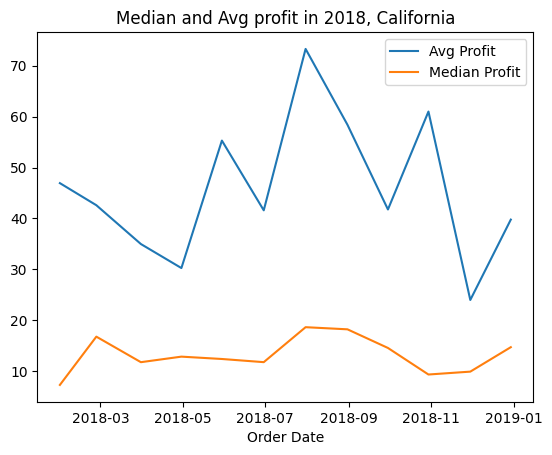

In [5]:
from datetime import date

query = (kawa
         .sheet('Super Store')
         .select(
             K.col('Order Date'),
             K.col('Profit').avg().alias('Avg Profit'),
             K.col('Profit').median().alias('Median Profit'),
         )
         .group_by('Order Date')
         .sample('YEAR_AND_MONTH')
         .filter(K.col('State').eq('California'))
         .filter(K.col('Order Date').date_range(
             from_inclusive=date(2018,1,1), 
             to_inclusive=date(2018,12,31))
         )
         .no_limit())

df = query.compute(use_group_names=True)

df.plot(x='Order Date', title="Median and Avg profit in 2018, California");

### 1.c Show all cities whose average profit is greater than 50 with more than 100 unique orders

In [6]:
query = (kawa
         .sheet('Super Store')
         .select(
             K.col('Profit').avg().alias('Avg Profit'),
             K.col('Order Id').count_unique().alias('Num unique orders'),
         )
         .group_by('City')
         .filter(K.col('Profit').avg().gt(50))
         .filter(K.col('Order Id').count_unique().gt(100))
         .order_by('Avg Profit')
         .no_limit())

query.compute(use_group_names=True)

,group(0) City,Avg Profit,Num unique orders
0,New York City,67.799982,450
1,Seattle,68.121721,212


### 1.d Show the repartition of customers per year and state

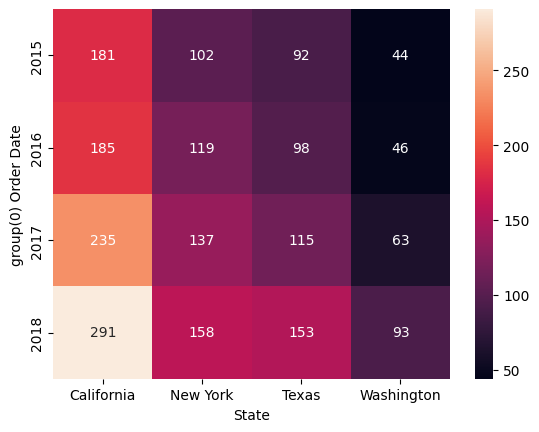

In [8]:
import seaborn as sns

query = (kawa
         .sheet('Super Store')
         .select(
             K.col('Order Date'),
             K.col('State'),
             K.col('Customer Name').count_unique().alias('num clients'),
         )
         .sample('YEAR',column_name='Order Date' )
         .group_by('Order Date', 'State')
         .filter(K.col('State').in_list(['California','Texas', 'Washington','New York']))
         .no_limit())

df = query.compute(use_group_names=True)

matrix = df.pivot_table(index="group(0) Order Date", columns="State", values="num clients")
sns.heatmap(matrix,  annot=True, fmt="0.0f");
